/Users/kashifmoin/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading dataset from Train.BioC.JSON...
Loaded 800 samples.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized Relation Encoder with BERT backbone.
Using Contrastive Margin Loss with margin: 1.0
Starting training...
Epoch 1 completed. Avg Loss: 0.4229
Epoch 2 completed. Avg Loss: 0.3092
Epoch 3 completed. Avg Loss: 0.2601
Extracting embeddings...
Extracted 800 embeddings.


/Users/kashifmoin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Evaluating clustering...
Silhouette Score: 0.2995
Calinski-Harabasz Score: 253.0175
Generating visualizations...


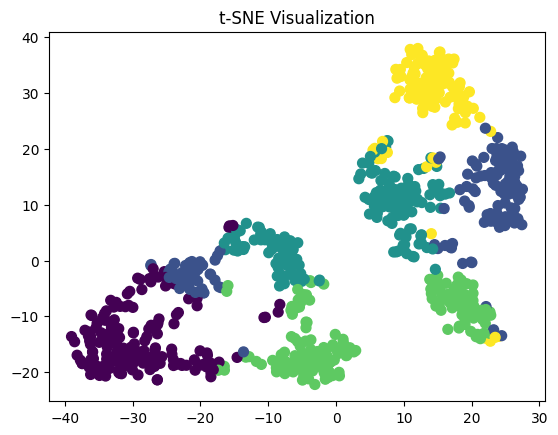

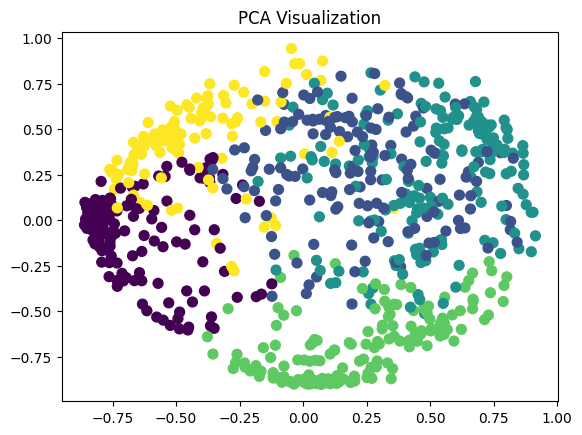

Training complete. Model saved as 'baseline_model.pth'.


In [ ]:
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


# Loading the dataset (BioC JSON)
class BioCDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=128):
        print(f"Loading dataset from {file_path}...")
        with open(file_path, 'r') as f:
            data = json.load(f)
        self.samples = []
        self.labels = None
        for doc in data.get("documents", []):
            for passage in doc.get("passages", []):
                text = passage.get("text", "")
                if text:
                    self.samples.append(text)
        self.tokenizer = tokenizer
        self.max_length = max_length
        print(f"Loaded {len(self.samples)} samples.")

# Returning the total number of samples in the dataset.
    def __len__(self):
        return len(self.samples)

# Retrieving a sample's text and tokenize it using the provided tokenizer.
    def __getitem__(self, idx):
        text = self.samples[idx]
        inputs = self.tokenizer(text, truncation=True, padding='max_length',
                                max_length=self.max_length, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, text


# Defining Relation Encoder Model.
class RelationEncoder(nn.Module):
    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(RelationEncoder, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.fc = nn.Linear(self.bert.config.hidden_size, 128)
        print("Initialized Relation Encoder with BERT backbone.")

    def forward(self, input_ids, attention_mask):
    # Passing inputs through BERT to obtain hidden states.
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    # Extracting the CLS token embedding, which serves as a summary representation.
        cls = outputs.last_hidden_state[:, 0, :]
     # Projecting the CLS embedding and normalize it.
        emb = self.fc(cls)
        emb = nn.functional.normalize(emb, p=2, dim=1)
        return emb


# Defining Augmentation Functions.
def within_sentence_augmentation(text):
    words = text.split()
    if len(words) <= 3:
        return text
    # Keeping each word with an 80% chance.
    new_words = [word for word in words if random.random() > 0.2]
    return " ".join(new_words)


# Defining Contrastive Margin Loss.
""" Implementing the Triplet Margin Loss used for contrastive learning.
    It encourages the model to bring the anchor and positive examples closer,
    while pushing the negative examples further apart by a specified margin."""
class ContrastiveMarginLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveMarginLoss, self).__init__()
        self.loss_fn = nn.TripletMarginLoss(margin=margin)
        print("Using Contrastive Margin Loss with margin:", margin)

    def forward(self, anchor, positive, negative):
        return self.loss_fn(anchor, positive, negative)


# Training the model.
"""
    Training the RelationEncoder model using contrastive learning:
      - Generating augmented text for positive samples.
      - Computing embeddings for the original (anchor) and augmented (positive) samples.
      - Shuffle positive embeddings to form negative samples.
      - Calculating the loss and updating model parameters.
    """
def train_model(model, dataset, tokenizer, epochs=3, batch_size=16, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    loss_fn = ContrastiveMarginLoss(margin=1.0)

    print("Starting training...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for i, (inputs, texts) in enumerate(dataloader):
            inputs_pos = tokenizer([within_sentence_augmentation(text) for text in texts],
                                   truncation=True, padding='max_length',
                                   max_length=dataset.max_length, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            inputs_pos = {k: v.to(device) for k, v in inputs_pos.items()}

            anchor_emb = model(inputs["input_ids"], inputs["attention_mask"])
            positive_emb = model(inputs_pos["input_ids"], inputs_pos["attention_mask"])
            perm = torch.randperm(anchor_emb.size(0))
            negative_emb = positive_emb[perm]

            loss = loss_fn(anchor_emb, positive_emb, negative_emb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} completed. Avg Loss: {total_loss/len(dataloader):.4f}")
    return model


# Clustering Evaluation
  """
    Using two popular metrics to assess clustering quality:
    Silhouette Score: higher values indicate better clustering.
    Calinski-Harabasz Score: higher values suggest more distinct clusters.
    """
def evaluate_clustering(embeddings, pred_labels):
    print("Evaluating clustering...")
    sil_score = silhouette_score(embeddings, pred_labels)
    ch_score = calinski_harabasz_score(embeddings, pred_labels)
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.4f}")


# Dimensionality Reduction & Visualization
  """
    Reducing the high-dimensional embeddings to two dimensions for visualization by using 2 Methods:
      - t-SNE for a non-linear view.
      - PCA for a linear view.
    The resulting plots are color-coded by cluster labels.
    """
def visualize_dimensionality_reduction(embeddings, pred_labels):
    print("Generating visualizations...")
    tsne = TSNE(n_components=2, random_state=0)
    emb_tsne = tsne.fit_transform(embeddings)
    plt.figure()
    plt.scatter(emb_tsne[:,0], emb_tsne[:,1], c=pred_labels, cmap="viridis", s=50)
    plt.title("t-SNE Visualization")
    plt.show()

    pca = PCA(n_components=2, random_state=0)
    emb_pca = pca.fit_transform(embeddings)
    plt.figure()
    plt.scatter(emb_pca[:,0], emb_pca[:,1], c=pred_labels, cmap="viridis", s=50)
    plt.title("PCA Visualization")
    plt.show()

# Extract Embeddings & Cluster
def extract_embeddings(model, dataset, tokenizer, batch_size=16, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    embeddings = []
    texts = []
    print("Extracting embeddings...")
    with torch.no_grad():
        for batch in dataloader:
            inputs, batch_texts = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            emb = model(inputs["input_ids"], inputs["attention_mask"])
            embeddings.append(emb.cpu().numpy())
            texts.extend(batch_texts)
    embeddings = np.concatenate(embeddings, axis=0)
    print(f"Extracted {len(embeddings)} embeddings.")
    return embeddings, texts


# Main Execution
 """
    The main function is orchestrates the entire workflow:
      1. Initializing the tokenizer and loading the BioC dataset.
      2. Seting up the RelationEncoder model.
      3. Training the model with contrastive learning.
      4. Extracting embeddings from the trained model.
      5. Clustering the embeddings using K-Means.
      6. Evaluating the clustering quality.
      7. Visualizing the clusters using t-SNE and PCA.
      8. Saving the trained model for future use.
    """
def main():
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    dataset = BioCDataset("Train.BioC.JSON", tokenizer)
    model = RelationEncoder()
    model = train_model(model, dataset, tokenizer, epochs=3, batch_size=8)
    embeddings, _ = extract_embeddings(model, dataset, tokenizer)
    kmeans = KMeans(n_clusters=5, random_state=0).fit(embeddings)
    evaluate_clustering(embeddings, kmeans.labels_)
    visualize_dimensionality_reduction(embeddings, kmeans.labels_)
    torch.save(model.state_dict(), "baseline_model.pth")
    print("Training complete. Model saved as 'baseline_model.pth'.")

if __name__ == "__main__":
    main()
